# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

#### 1.1.1: Importing Libraries

In [ ]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


#### 1.1.2: Data Preparation

**Display Images Function**

In [ ]:
# Function to display images
def show_images(dataloader, classes, num_images=4):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Denormalize the images (if they were previously normalized)
    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.5, 0.5, 0.5])
    images = images * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)

    # Convert images to numpy arrays for plotting
    np_images = images.numpy()
    np_images = np.transpose(np_images, (0, 2, 3, 1))

    # Plot the images
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(np_images[i])
        axes[i].set_title(f'Label: {classes[labels[i]]}')
        axes[i].axis('off')
    plt.show()


**ID dataset**

For the ID dataset I consider CIFAR-10 as in the video example of the lesson.

In [ ]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load train set and test set
batch_size = 32
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Train-Val split
val_size = int(0.1 * len(ds_train))
I = np.random.permutation(len(ds_train))
ds_train = Subset(ds_train, I[val_size:])
ds_val = Subset(ds_train, I[:val_size])

# Setup DataLoaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=batch_size, shuffle=False, num_workers=2)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

# In case we want to pretty-print classifications.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:12<00:00, 13116081.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Check images

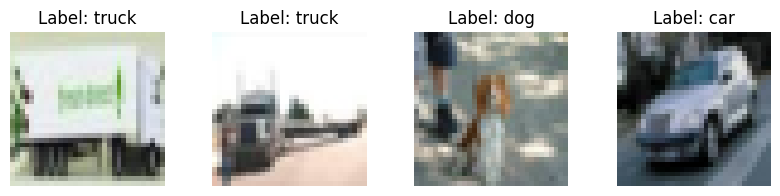

In [ ]:
show_images(dl_train, classes)

**OOD dataset**

As OOD dataset, I selected a subset of CIFAR-100. Since there some overlaps between categories of classes of CIFAR-10 and CIFAR-100, as a subset of the latter I decided to select classes which categories do not belong to the first one. In this case I decided to take in consideration "house objects". Infact, since CIFAR-10 contains categories belonging to "animals" and "vehicles", hopefully this selection should lead to a more discriminative detection.

In [ ]:
# OOD dataset
cifar100_ds = CIFAR100(root='./data', train=True, download=True, transform=transform)

# Take a subset of CIFAR-100 which cateogories belong to 'house objects'
ood_classes = ['bottle', 'clock', 'plate', 'telephone']
ood_classes_idx = {c:cifar100_ds.class_to_idx[c] for c in ood_classes}
ood_idx_classes = {v:k for k, v in ood_classes_idx.items()}
ood_indices = [i for i in range(len(cifar100_ds)) if cifar100_ds.targets[i] in ood_classes_idx.values()]

# Compute the subset
ds_fake = Subset(cifar100_ds, ood_indices)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size = batch_size, shuffle = False, num_workers = 2)

100%|██████████| 169001437/169001437 [00:12<00:00, 13317560.72it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data


Check images

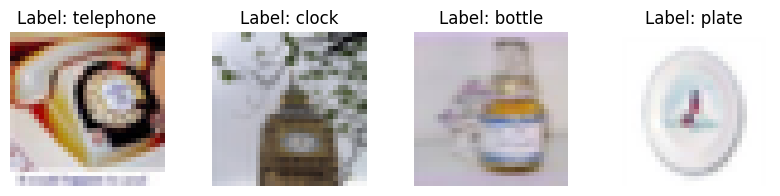

In [ ]:
show_images(dl_fake, cifar100_ds.classes)

#### 1.1.3: Model

I am using the same model from the flipped class notebook

In [ ]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**Training the base model or load it**

This code is taken from the flipped class activity, and can be used either to upload the already trained model or to train it from scratch.

For this activity I will upload it already trained.

In [ ]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = CNN().to(device)
model.load_state_dict(torch.load('./cifar10_CNN.pth', map_location=device))
model = model.to(device)

In [ ]:
# USE THIS CELL TO TRAIN MODEL FROM SCRATCH.
model = CNN().to(device)

# Train for only 50 epochs.
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Main training loop.
for epoch in range(epochs):
    running_loss = 0.0
    # Iterate over all batches.
    for (i, (Xs, ys)) in enumerate(dl_train, 0):
        Xs = Xs.to(device)
        ys = ys.to(device)

        # Make a gradient step.
        optimizer.zero_grad()
        outputs = model(Xs)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()

        # Track epoch loss.
        running_loss += loss.item()

    # Print average epoch loss.
    print(f'{epoch + 1} loss: {running_loss / len(dl_train):.3f}')

print('Finished Training')
torch.save(model.state_dict(), './cifar10_CNN.pth')

#### 1.1.4: Analyzing In Distribution (ID) and OOD behavior.

The simplest thing we could do, ideally, is just look at the logit response from the model. If the max logit is "too low", it *must* be an OOD sample. Let's try...

In [ ]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)

In [ ]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_fake)

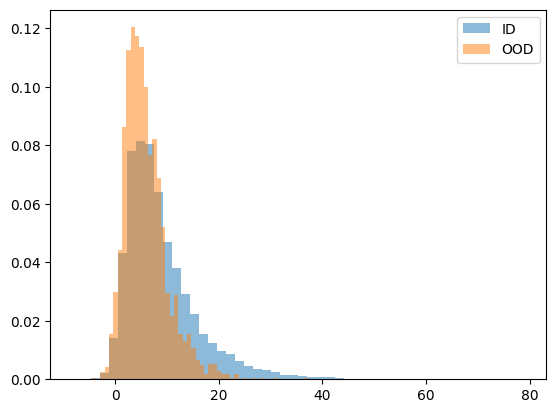

In [ ]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

As anticipated by the lesson, there is a lot of overlapping between the 2 curves, even if we did not expect that. Infact, I selected categories different from the CIFAR-10 dataset to create a subset of CIFAR-100 with the goal to have a more different results.
This results confirm what has been told during the lesson, hence **max logits** is not a good discriminative metric for this kind of task.

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, PrecisionRecallDisplay, precision_recall_curve,  roc_curve, auc, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay


**ROC and AUC**

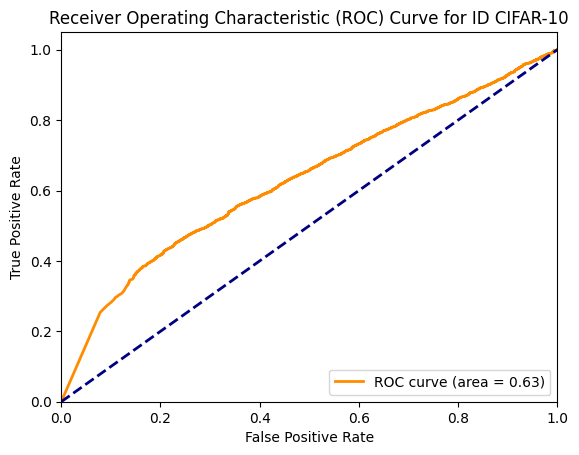

In [ ]:
# Take the logits from the take section and use softmax function to transform them in probabilities
temp = 0.5
id_probs = F.softmax(torch.tensor(logits_ID/temp), dim=1).numpy()
ood_probs = F.softmax(torch.tensor(logits_OOD/temp), dim=1).numpy()

# Since scikit-learn functions do not support multi class classification, we use ID pred as pos and OOD pred as neg
all_labels = np.hstack([np.ones_like(id_probs.max(1)), np.zeros_like(ood_probs.max(1))])
all_preds = np.hstack([id_probs.max(1), ood_probs.max(1)])

fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc_id = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_id)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ID CIFAR-10')
plt.legend(loc="lower right")
plt.show()

The achieved AUC of 0.63 indicates that the Out-of-Distribution (OOD) detection system is capable of distinguishing between in-distribution and out-of-distribution samples with moderate effectiveness. An AUC value closer to 1 would indicate a stronger discriminative ability. Although the current AUC suggests some level of differentiation, there is room for improvement to enhance the system's performance.

**Precision-Recall Curve**

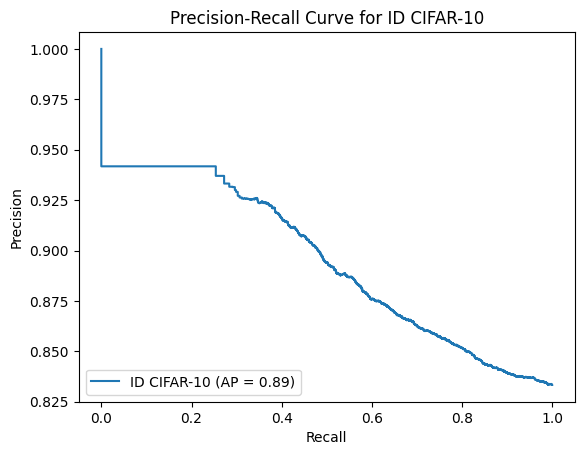

In [ ]:
precision, recall, _ = precision_recall_curve(all_labels, all_preds)

# Calculate Precision-Recall curve and PR-AUC score for both ID and OOD scoring
#precision_id, recall_id, _ = precision_recall_curve(all_labels == 1, all_predictions)
pr_auc_id = average_precision_score(all_labels, all_preds)

# Plot Precision-Recall curve
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc_id, estimator_name='ID CIFAR-10')
pr_display.plot()
plt.title('Precision-Recall Curve for ID CIFAR-10')
plt.show()

The computed AP of 0.89 implies that the OOD detection system is effective in ranking the relevance of detected out-of-distribution samples during the precision-recall analysis. An AP value closer to 1 signifies better precision and recall balance. The high AP value indicates the system's ability to achieve both high precision (low false positive rate) and high recall (low false negative rate).

---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks.

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are.

#### 2.1.1: FGSM Attack

First, I want to calculate the accuracy of the model, before the attack.

In [ ]:
model = model.to(device)

In [ ]:
model.eval()

# Function to calculate accuracy on a given dataloader
def get_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Calculate accuracy on the test set before the attack
accuracy_before_attack = get_accuracy(model, dl_test)
print(f"Accuracy on the test set before the attack: {accuracy_before_attack:.4f}")

Accuracy on the test set before the attack: 0.6008


Then I implement the FGSM attack function

In [ ]:
# Implement the FGSM attack
def fgsm_attack(model, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()
    perturbed_data = data + epsilon * data.grad.data.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Clip perturbed data to [0, 1]
    return perturbed_data

#### 2.1.2: Qualitative Evaluation

Before jumping on a quantitative evaluation, I wanted to display the images before and after the attack. I chose a value of epsilon equal to 0.1, but 0.02 (as the future quantitative evaluation suggests) is already enough to ruin the image at the point which the accuracy drop from 60% to about 20%.

In [ ]:
def show_images(model, dataloader, classes, attack=None, epsilon=None, num_images=4):
    model.eval()
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Display images before the attack
    print("Images before the attack:")
    np_images = images.numpy()
    np_images = np.transpose(np_images, (0, 2, 3, 1))
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i in range(num_images):
        axes[i].imshow(np_images[i])
        axes[i].set_title(f'Label: {classes[labels[i]]}')
        axes[i].axis('off')
    plt.show()

    # Generate adversarial examples (if attack is provided)
    if attack is not None and epsilon is not None:
        images = images.to(device)
        labels = labels.to(device)
        perturbed_images = attack(model, images, labels, epsilon)
        perturbed_outputs = model(perturbed_images)
        _, perturbed_predictions = torch.max(perturbed_outputs, 1)

        # Display images after the attack
        print("Images after the attack:")
        np_perturbed_images = perturbed_images.detach().cpu().numpy()
        np_perturbed_images = np.transpose(np_perturbed_images, (0, 2, 3, 1))
        fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
        for i in range(num_images):
            axes[i].imshow(np_perturbed_images[i])
            axes[i].set_title(f'Label: {classes[perturbed_predictions[i]]}')
            axes[i].axis('off')
        plt.show()


Epsilon = 0.01

FGSM attack with epsilon = 0.01


Images before the attack:


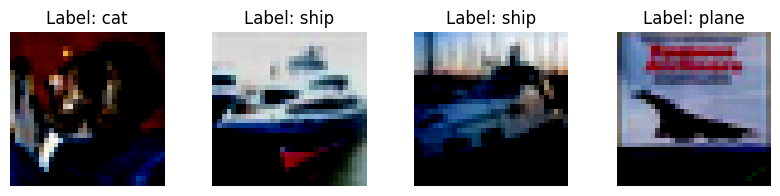

Images after the attack:


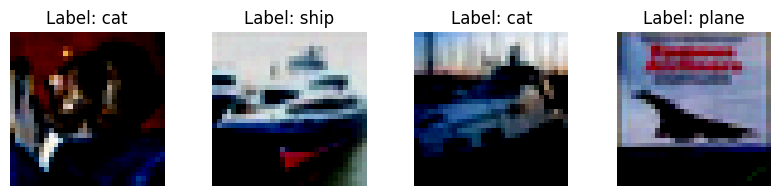

In [ ]:
print(f"FGSM attack with epsilon = {0.01}")
show_images(model, dl_test, classes, attack=fgsm_attack, epsilon=0.01, num_images=4)

Epsilon = 0.1

FGSM attack with epsilon = 0.1
Images before the attack:


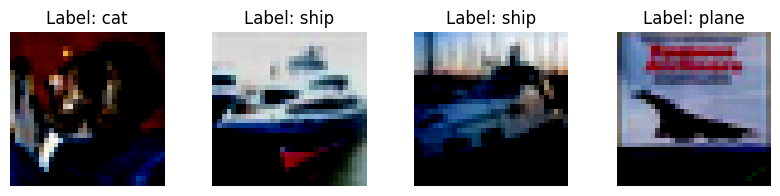

Images after the attack:


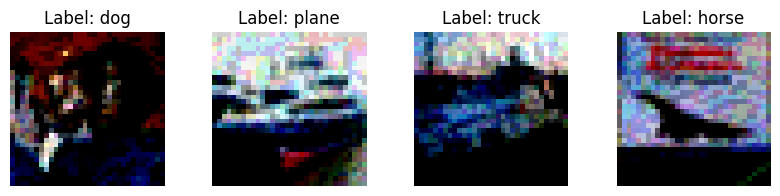

In [ ]:
print(f"FGSM attack with epsilon = {0.1}")
show_images(model, dl_test, classes, attack=fgsm_attack, epsilon=0.1, num_images=4)

Epsilon = 0.3

FGSM attack with epsilon = 0.3
Images before the attack:


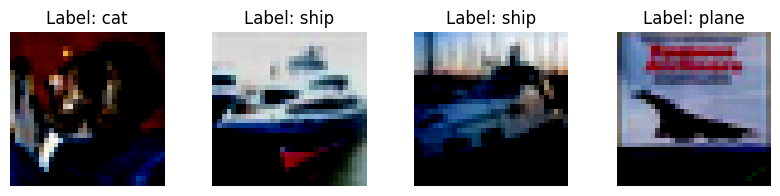

Images after the attack:


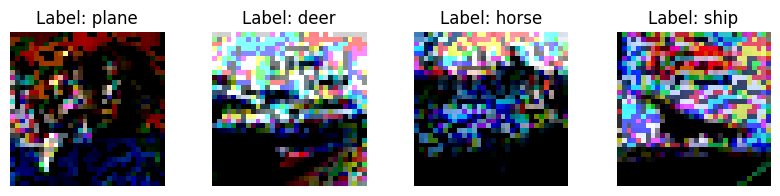

In [ ]:
print(f"FGSM attack with epsilon = {0.3}")
show_images(model, dl_test, classes, attack=fgsm_attack, epsilon=0.3, num_images=4)

These results suggest that the attack is effective! And as the quantitative resuls will show, the quality drops exponentially. Indeed, from 0.1 to 0.3 the image is almost unrecognizible.

#### 2.1.3: Quantitative Evaluation

Now I will provie a quantitative evaluation. Recall that the model accuracy before the attack was about 60%, we can see that with just an epsilon of 0.01 the accuracy dramatically drops to 30%, and as we espect, the more we grow and the worse it becomes.

In [ ]:
# Function to evaluate accuracy on adversarial examples for different epsilon values
def evaluate_adversarial_accuracy(model, dataloader, epsilon_values):
    accuracies = []
    for epsilon in epsilon_values:
        correct = 0
        total = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            perturbed_inputs = fgsm_attack(model, inputs, labels, epsilon)
            outputs = model(perturbed_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)
    return accuracies

And plot the values of the accuracy after the attack as a function of the values of epsilon

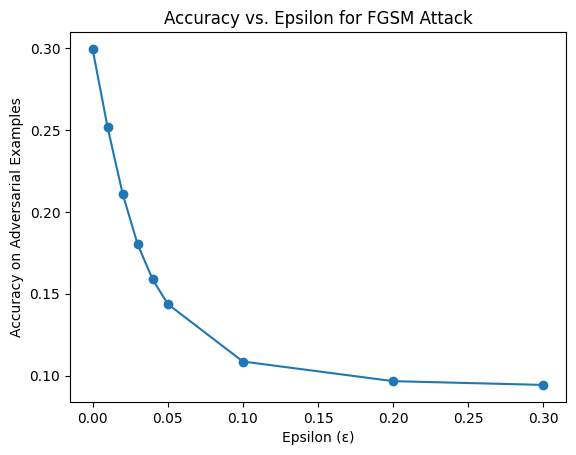

In [ ]:
# Choose a range of epsilon values to evaluate
epsilon_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]

# Evaluate accuracy on adversarial examples
adversarial_accuracies = evaluate_adversarial_accuracy(model, dl_test, epsilon_values)

# Visualize the results
plt.plot(epsilon_values, adversarial_accuracies, marker='o')
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy on Adversarial Examples')
plt.title('Accuracy vs. Epsilon for FGSM Attack')
plt.show()


The trend drops exponentially, and eventually stabilize. The quantitative results confirm the qualitative results we have seen previously.

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

#### 2.2.1: Train the robus_model with FGSM attacks

**Define training loop**

This training loop will call the **fgsm_attack** at each iteration in order to have a data augmentation at the *fly*.

In [ ]:
# Training loop with adversarial examples
def train(model, trainloader, optimizer, criterion, epsilon):
    model.train()
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Clean data training
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Adversarial training
        perturbed_inputs = fgsm_attack(model, inputs, labels, epsilon)
        optimizer.zero_grad()
        perturbed_outputs = model(perturbed_inputs)
        loss_adv = criterion(perturbed_outputs, labels)
        loss_adv.backward()
        optimizer.step()

modified train loop

In [ ]:
def train(model, dataloader, optimizer, criterion, epsilon):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero out gradients
        optimizer.zero_grad()

        # Clean data training
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Adversarial training
        perturbed_inputs = fgsm_attack(model, inputs, labels, epsilon)
        perturbed_outputs = model(perturbed_inputs)
        loss_adv = criterion(perturbed_outputs, labels)
        loss_adv.backward()

        # Update parameters
        optimizer.step()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item() + loss_adv.item()

    accuracy_train = 100 * correct / total
    loss_train = running_loss / len(dataloader)

    return accuracy_train, loss_train


In [ ]:
def fgsm_attack(model, data, target, epsilon):
    model.eval()  # Set the model to evaluation mode
    for param in model.parameters():
        param.requires_grad = True

    data.requires_grad = True
    output = model(data)
    loss = F.cross_entropy(output, target)
    model.zero_grad()
    loss.backward()

    # Create a copy of the data that requires gradient computation
    perturbed_data = data.detach() + epsilon * data.grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Clip perturbed data to [0, 1]
    perturbed_data.requires_grad = True

    return perturbed_data


In [ ]:
# Function to evaluate accuracy on adversarial examples for different epsilon values
def evaluate_adversarial_accuracy(model, dataloader, epsilon):
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        perturbed_inputs = fgsm_attack(model, inputs, labels, epsilon)
        outputs = model(perturbed_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

**robust_model and training**

I am defining a new model with the same architecture as before, to have a fair comparison and call it **robust_model** since I am expecting it to be robust, since it is trained on attacked samples.

In [ ]:
# Initialize model, optimizer, and criterion
robust_model = CNN()
robust_model = robust_model.to(device)
optimizer = optim.Adam(robust_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 50
epsilon = 0.1  # Set the desired epsilon value for FGSM attack

In [ ]:
# Training loop
for epoch in range(epochs):
    accuracy_train, loss_train = train(robust_model, dl_train, optimizer, criterion, epsilon)

    # Calculate test accuracy and loss
    accuracy_test = evaluate_adversarial_accuracy(robust_model, dl_test, epsilon)

    # Print the results for each epoch
    print(f"Epoch: {epoch + 1}, Epsilon: {epsilon:.2f}, Train Accuracy: {accuracy_train:.2f}%, Train Loss: {loss_train:.4f}, Test Accuracy: {accuracy_test:.2f}%")

In [ ]:
model_path = 'robust_cifar10_CNN.pth'
torch.save(robust_model.state_dict(), model_path)


In [ ]:
robust_model = robust_model.to(device)

#### 2.1.3: Quantitative Evaluation

Now I will provie a quantitative evaluation. I want to compare the pre-trained **model** versus the **robust_model** trained with *fgsm attack* with epsilon equal to 1.

In [ ]:
# Function to evaluate accuracy on adversarial examples for different epsilon values
def evaluate_adversarial_accuracy(model, dataloader, epsilon_values):
    accuracies = []
    for epsilon in epsilon_values:
        correct = 0
        total = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            perturbed_inputs = fgsm_attack(model, inputs, labels, epsilon)
            outputs = model(perturbed_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)
    return accuracies

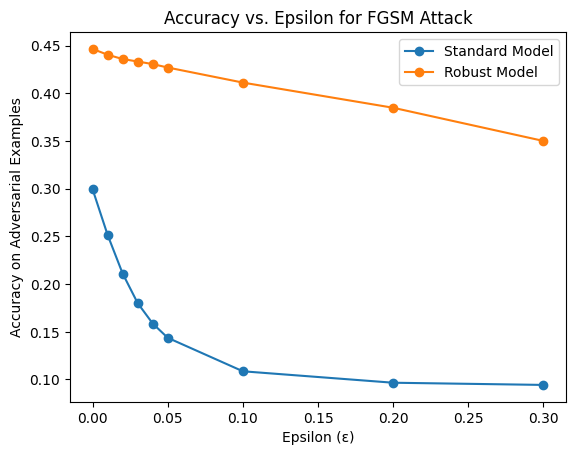

In [ ]:
# Choose a range of epsilon values to evaluate
epsilon_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]

# Evaluate accuracy on adversarial examples
standard_model_accuracies = evaluate_adversarial_accuracy(model, dl_test, epsilon_values)
robust_model_accuracies = evaluate_adversarial_accuracy(robust_model, dl_test, epsilon_values)

# Plot the accuracies vs. epsilon values
plt.plot(epsilon_values, standard_model_accuracies, label='Standard Model', marker='o')
plt.plot(epsilon_values, robust_model_accuracies, label='Robust Model', marker='o')

# Add labels, title, and legend
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy on Adversarial Examples')
plt.title('Accuracy vs. Epsilon for FGSM Attack')
plt.legend()

# Show the plot
plt.show()


The blue line is the standard model accuracy calculated on the samples that received a fgsm attack and it has the same trend as before, of course. The orange one is the other trained on fgsm attacked samples, and as we can notice, it is much more robust than the standard one. This shows the importance of training a model on attacked samples.
Moreover, the model was trained with an epsilon = 0.1, but still it is robust with respect to bigger values of epsilon, while the blue one drop exponentially with greater values of epsilon.

#### 2.1.4: OOD Detection
Let's use the previous ood-pipeline to evaluate the **robust_model**

**OOD detection with logits**

In [ ]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(robust_model, dl_test)
logits_OOD = collect_logits(robust_model, dl_fake)

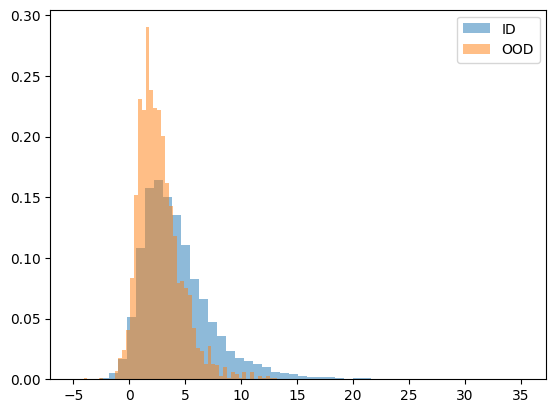

In [ ]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

Even if the model was trained on attacked sample, unfortunately, it does not show a very distintive difference with OOD samples. That, again, means that the max-logits is not a good way for OOD-detection.

**ROC and AUC**

Let's try to use more advanced techniques, like in the previous exercise, with Area Under the Curve of ROC and the Precision-Recall curve.

In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, PrecisionRecallDisplay, precision_recall_curve,  roc_curve, auc, precision_recall_curve, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay


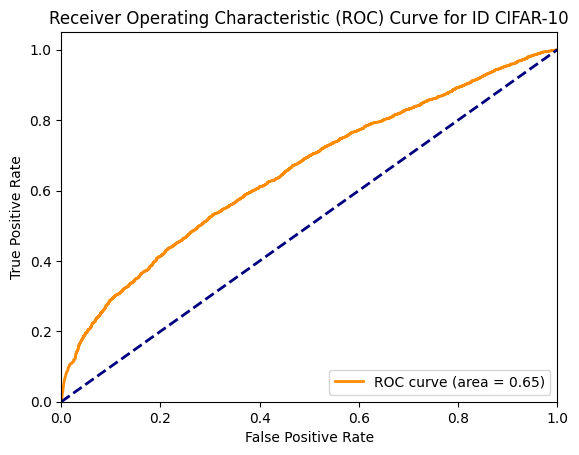

In [ ]:
# Take the logits from the take section and use softmax function to transform them in probabilities
temp = 0.5
id_probs = F.softmax(torch.tensor(logits_ID/temp), dim=1).numpy()
ood_probs = F.softmax(torch.tensor(logits_OOD/temp), dim=1).numpy()

# Since scikit-learn functions do not support multi class classification, we use ID pred as pos and OOD pred as neg
all_labels = np.hstack([np.ones_like(id_probs.max(1)), np.zeros_like(ood_probs.max(1))])
all_preds = np.hstack([id_probs.max(1), ood_probs.max(1)])

fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc_id = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_id)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for ID CIFAR-10')
plt.legend(loc="lower right")
plt.show()

The achieved AUC of 0.65 indicates a slight improvement respect the previous model. It indicates that the Out-of-Distribution (OOD) detection system is capable of distinguishing between in-distribution and out-of-distribution samples with moderate effectiveness. An AUC value closer to 1 would indicate a stronger discriminative ability. Although the current AUC suggests some level of differentiation, there is room for improvement to enhance the system's performance.

**Precision-Recall Curve**

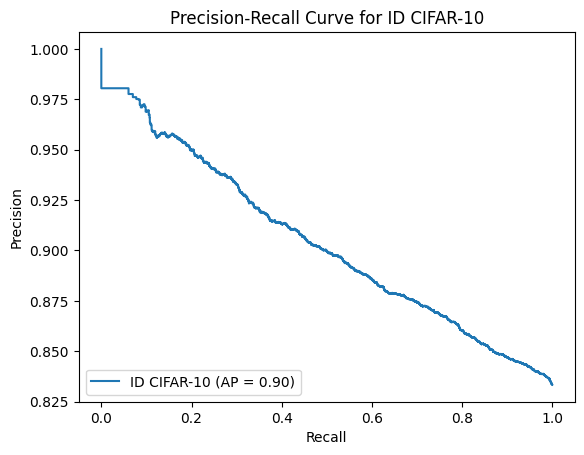

In [ ]:
precision, recall, _ = precision_recall_curve(all_labels, all_preds)

# Calculate Precision-Recall curve and PR-AUC score for both ID and OOD scoring
#precision_id, recall_id, _ = precision_recall_curve(all_labels == 1, all_predictions)
pr_auc_id = average_precision_score(all_labels, all_preds)

# Plot Precision-Recall curve
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall, average_precision=pr_auc_id, estimator_name='ID CIFAR-10')
pr_display.plot()
plt.title('Precision-Recall Curve for ID CIFAR-10')
plt.show()

The computed AP of 0.90 show a slight improvement with respect to the previous model, not so impressive. We have to admit that it was already high with the standard model.
Overral, this result implies that the OOD detection system is effective in ranking the relevance of detected out-of-distribution samples during the precision-recall analysis. An AP value closer to 1 signifies better precision and recall balance. The high AP value indicates the system's ability to achieve both high precision (low false positive rate) and high recall (low false negative rate).

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.


## Exercise 3.3: Experiment with *targeted* adversarial attacks

In this section I have implement the Fast Gradient Sign Method for generating targeted attacks, in order for the samples to *imitate* samples from a specific class.

I then evaluated the adversarial samples quantiatively, comparing the **standard model** with the **robust model** previously trained on the general fgsm.
For doing it I have plotted the accuracy over the targeted attacked samples in function of the value of *epsilon*.

Then, I evaluated the adversarial samples qualitatively with 3 plots:

1. Plot of clean images with predictions of standard model.
2. Plot of perturbed images with predictions of standard model.
3. Plot of perturbed images with predictions of robust model.

### Target FGSM attack

In [ ]:
import torch
import torch.nn.functional as F

def targeted_fgsm_attack(model, data, target_class, epsilon):
    model.eval()
    data.requires_grad = True

    output = model(data)
    target = torch.full((data.size(0),), target_class, dtype=torch.long, device=data.device)
    loss = F.cross_entropy(output, target)  # Loss for the target class
    model.zero_grad()
    loss.backward()

    # Compute the perturbation and add it to the data
    perturbation = epsilon * data.grad.data.sign()
    perturbed_data = data + perturbation
    perturbed_data = torch.clamp(perturbed_data, 0, 1)  # Clip perturbed data to [0, 1]

    return perturbed_data


### Quantitative Evaluation

In [ ]:
def evaluate_targeted_adversarial_accuracy(model, dataloader, target_class, epsilon_values):
    accuracies = []
    for epsilon in epsilon_values:
        correct = 0
        total = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            perturbed_inputs = targeted_fgsm_attack(model, inputs, target_class, epsilon)
            outputs = model(perturbed_inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = correct / total
        accuracies.append(accuracy)
    return accuracies


In [ ]:
# Choose the target class (change this to the desired target class index)
target_class = 7

# Choose a range of epsilon values to evaluate
epsilon_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3]

# Evaluate accuracy on targeted adversarial examples
standard_model_accuracies_targeted = evaluate_targeted_adversarial_accuracy(model, dl_test, target_class, epsilon_values)
robust_model_accuracies_targeted = evaluate_targeted_adversarial_accuracy(robust_model, dl_test, target_class, epsilon_values)


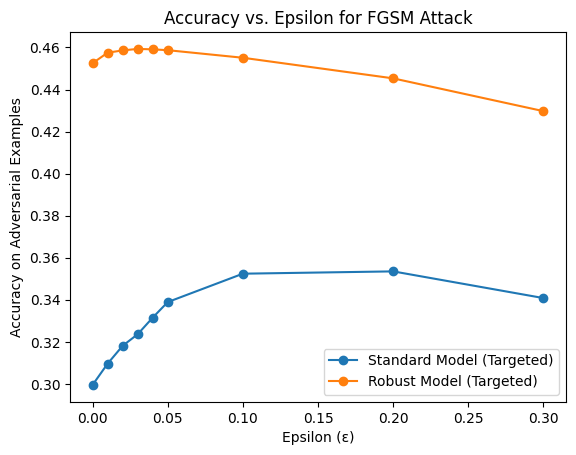

In [ ]:
# Plot the accuracies vs. epsilon values
plt.plot(epsilon_values, standard_model_accuracies_targeted, label='Standard Model (Targeted)', marker='o')
plt.plot(epsilon_values, robust_model_accuracies_targeted, label='Robust Model (Targeted)', marker='o')

# Add labels, title, and legend
plt.xlabel('Epsilon (ε)')
plt.ylabel('Accuracy on Adversarial Examples')
plt.title('Accuracy vs. Epsilon for FGSM Attack')
plt.legend()

# Show the plot
plt.show()


The graph shows once again that the **robust model** is actually more robust with respect to the perturbations. Infact, he didn't lose much accuracy, and the trend seems to be *linear* with the value of epsilon.
The **standard model** instead, showed a strange path, growin in accuracy (still under the 60% on normal set), from 30% and then startin descending again.

### Qualitative Evaluation


In this section I wanted to evaluate adversarial samples qualitatively with 3 plots:

1. Plot of clean images with predictions of standard model.
2. Plot of perturbed images with predictions of standard model.
3. Plot of perturbed images with predictions of robust model.

In [ ]:
import matplotlib.pyplot as plt

def display_grid(images, titles, num_images_per_row=4):
    num_rows = (len(images) + num_images_per_row - 1) // num_images_per_row
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, num_rows*4))
    for i, (image, title) in enumerate(zip(images, titles)):
        row = i // num_images_per_row
        col = i % num_images_per_row
        image = image.detach().cpu().numpy().transpose((1, 2, 0))

        # Normalize pixel values to [0, 1]
        image = (image - image.min()) / (image.max() - image.min())

        axes[row, col].imshow(image)
        axes[row, col].set_title(title)
        axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

# Generate targeted adversarial samples and test on model and robust_model
target_class = 7  # Target class index you want to imitate
epsilon = 0.1  # Set the epsilon value for the targeted FGSM attack

data_iter = iter(dl_test)
images, labels = next(data_iter)
perturbed_images = targeted_fgsm_attack(model, images.to(device), target_class, epsilon)
perturbed_images_robust = targeted_fgsm_attack(robust_model, images.to(device), target_class, epsilon)

# Display the images in a grid
images_before_perturbation = images.cpu()
images_after_perturbation = perturbed_images.cpu()
images_after_perturbation_robust = perturbed_images_robust.cpu()

titles = [f"Label: {classes[labels[j]]}\nPredicted: {classes[torch.max(model(images.to(device))[j], 0)[1]]}" for j in range(len(images))]
titles_perturbed = [f"Label: {classes[labels[j]]}\nPredicted: {classes[torch.max(model(perturbed_images)[j], 0)[1]]}" for j in range(len(perturbed_images))]
titles_perturbed_robust = [f"Label: {classes[labels[j]]}\nPredicted: {classes[torch.max(robust_model(perturbed_images_robust)[j], 0)[1]]}" for j in range(len(perturbed_images_robust))]

Before Perturbation with Standard Model


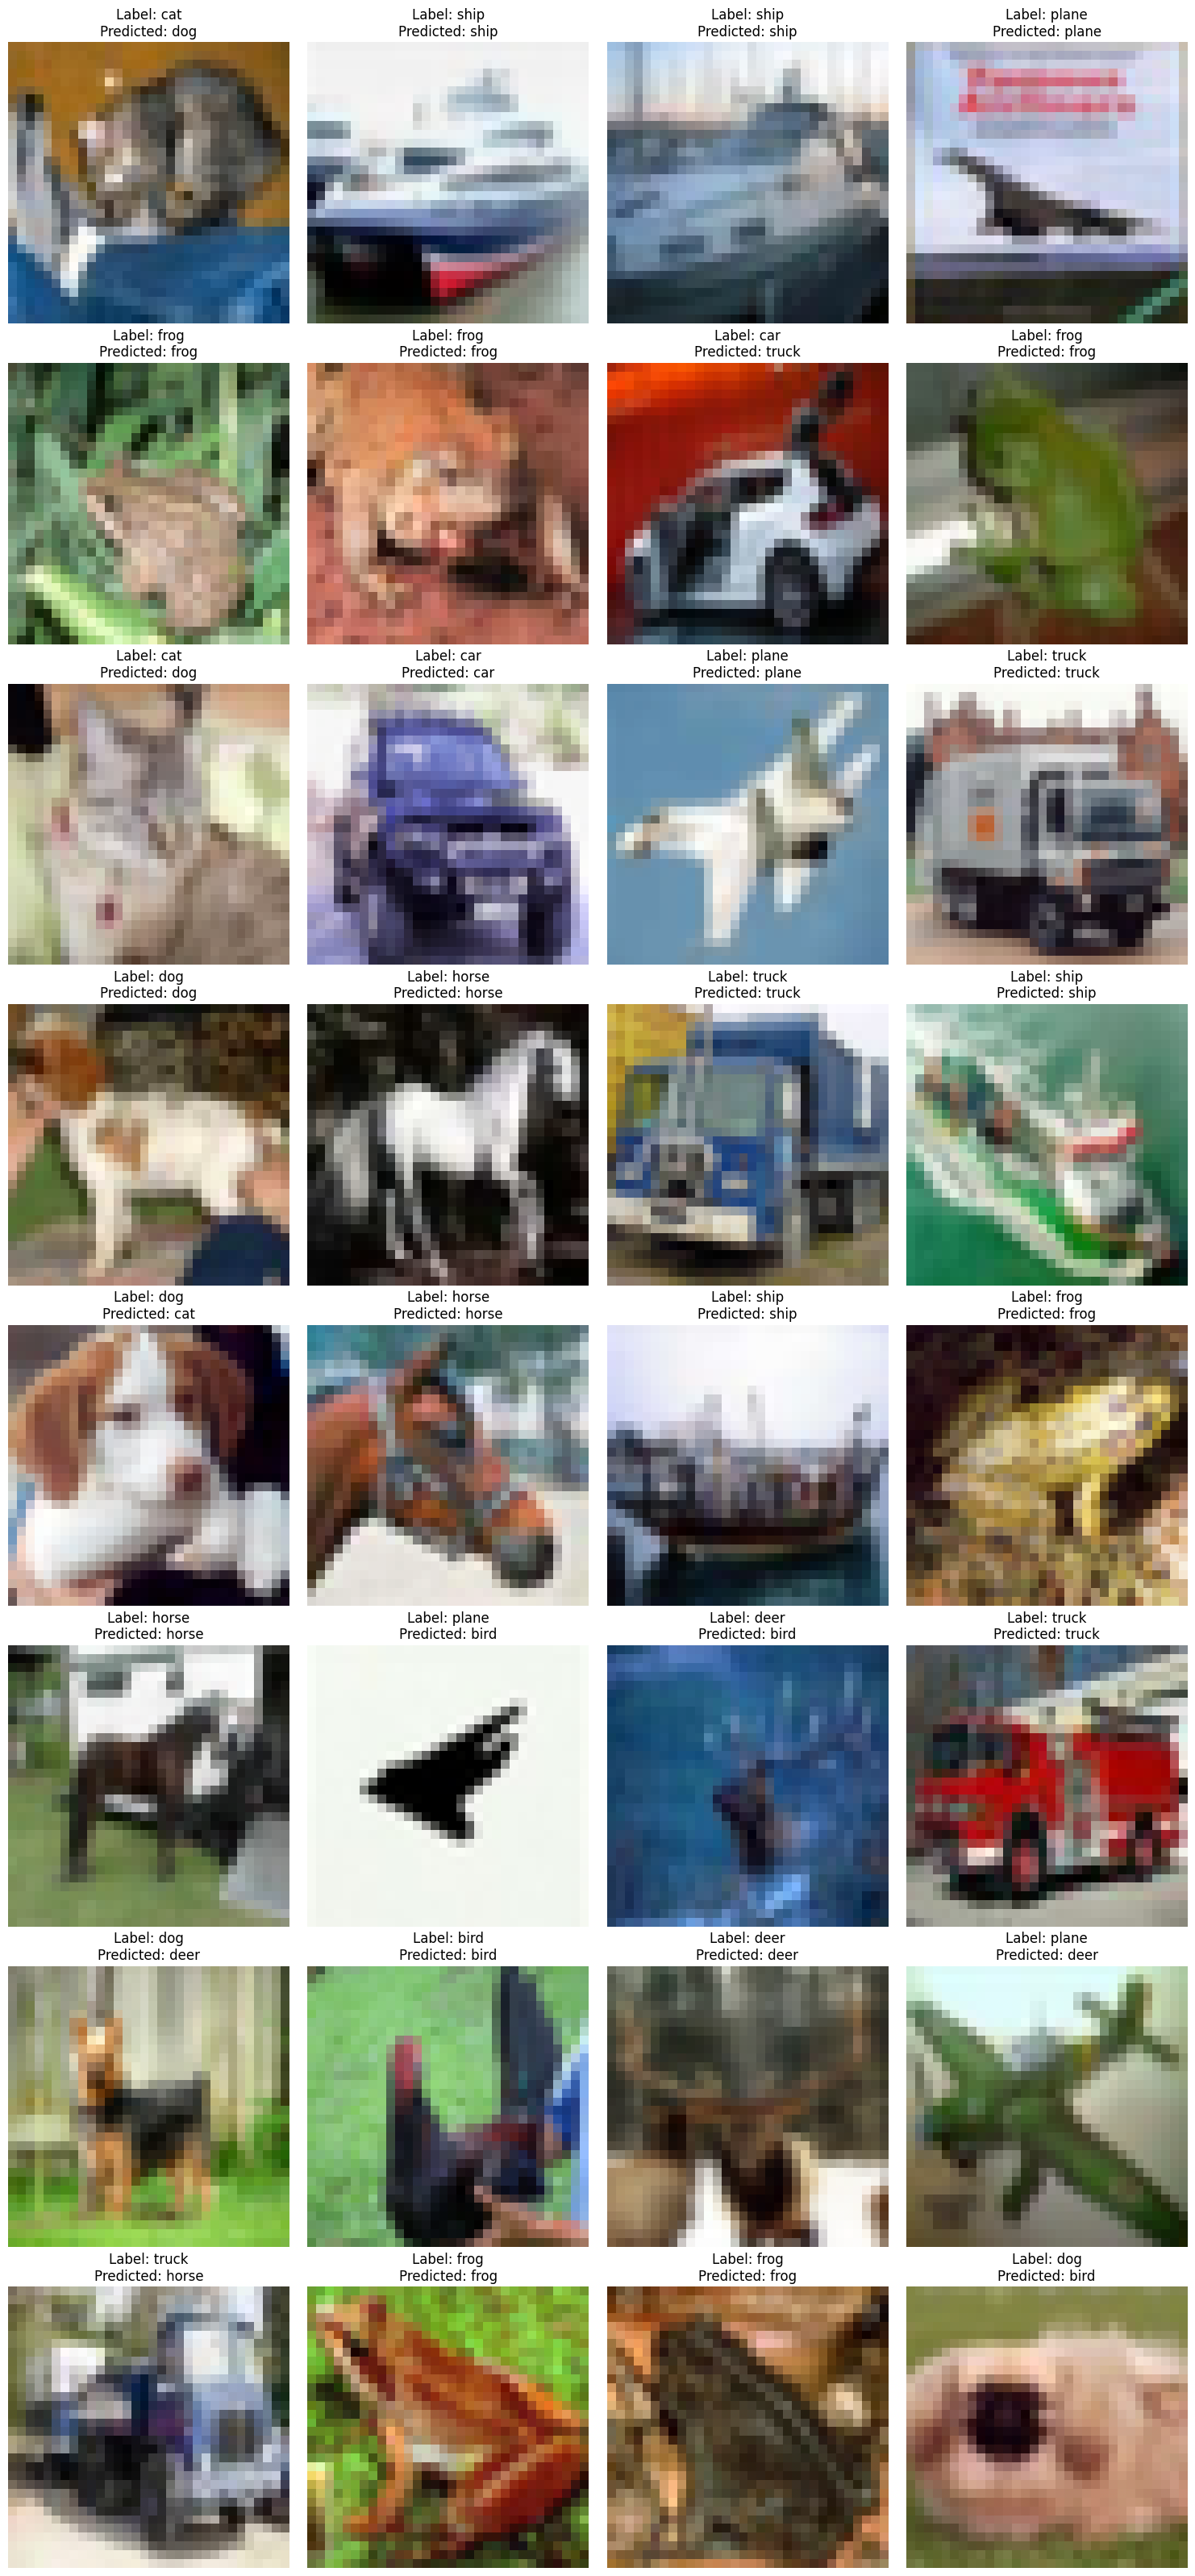

In [ ]:
print('Before Perturbation with Standard Model')
display_grid(images_before_perturbation, titles, num_images_per_row=4)

After Perturbation with Standard Model


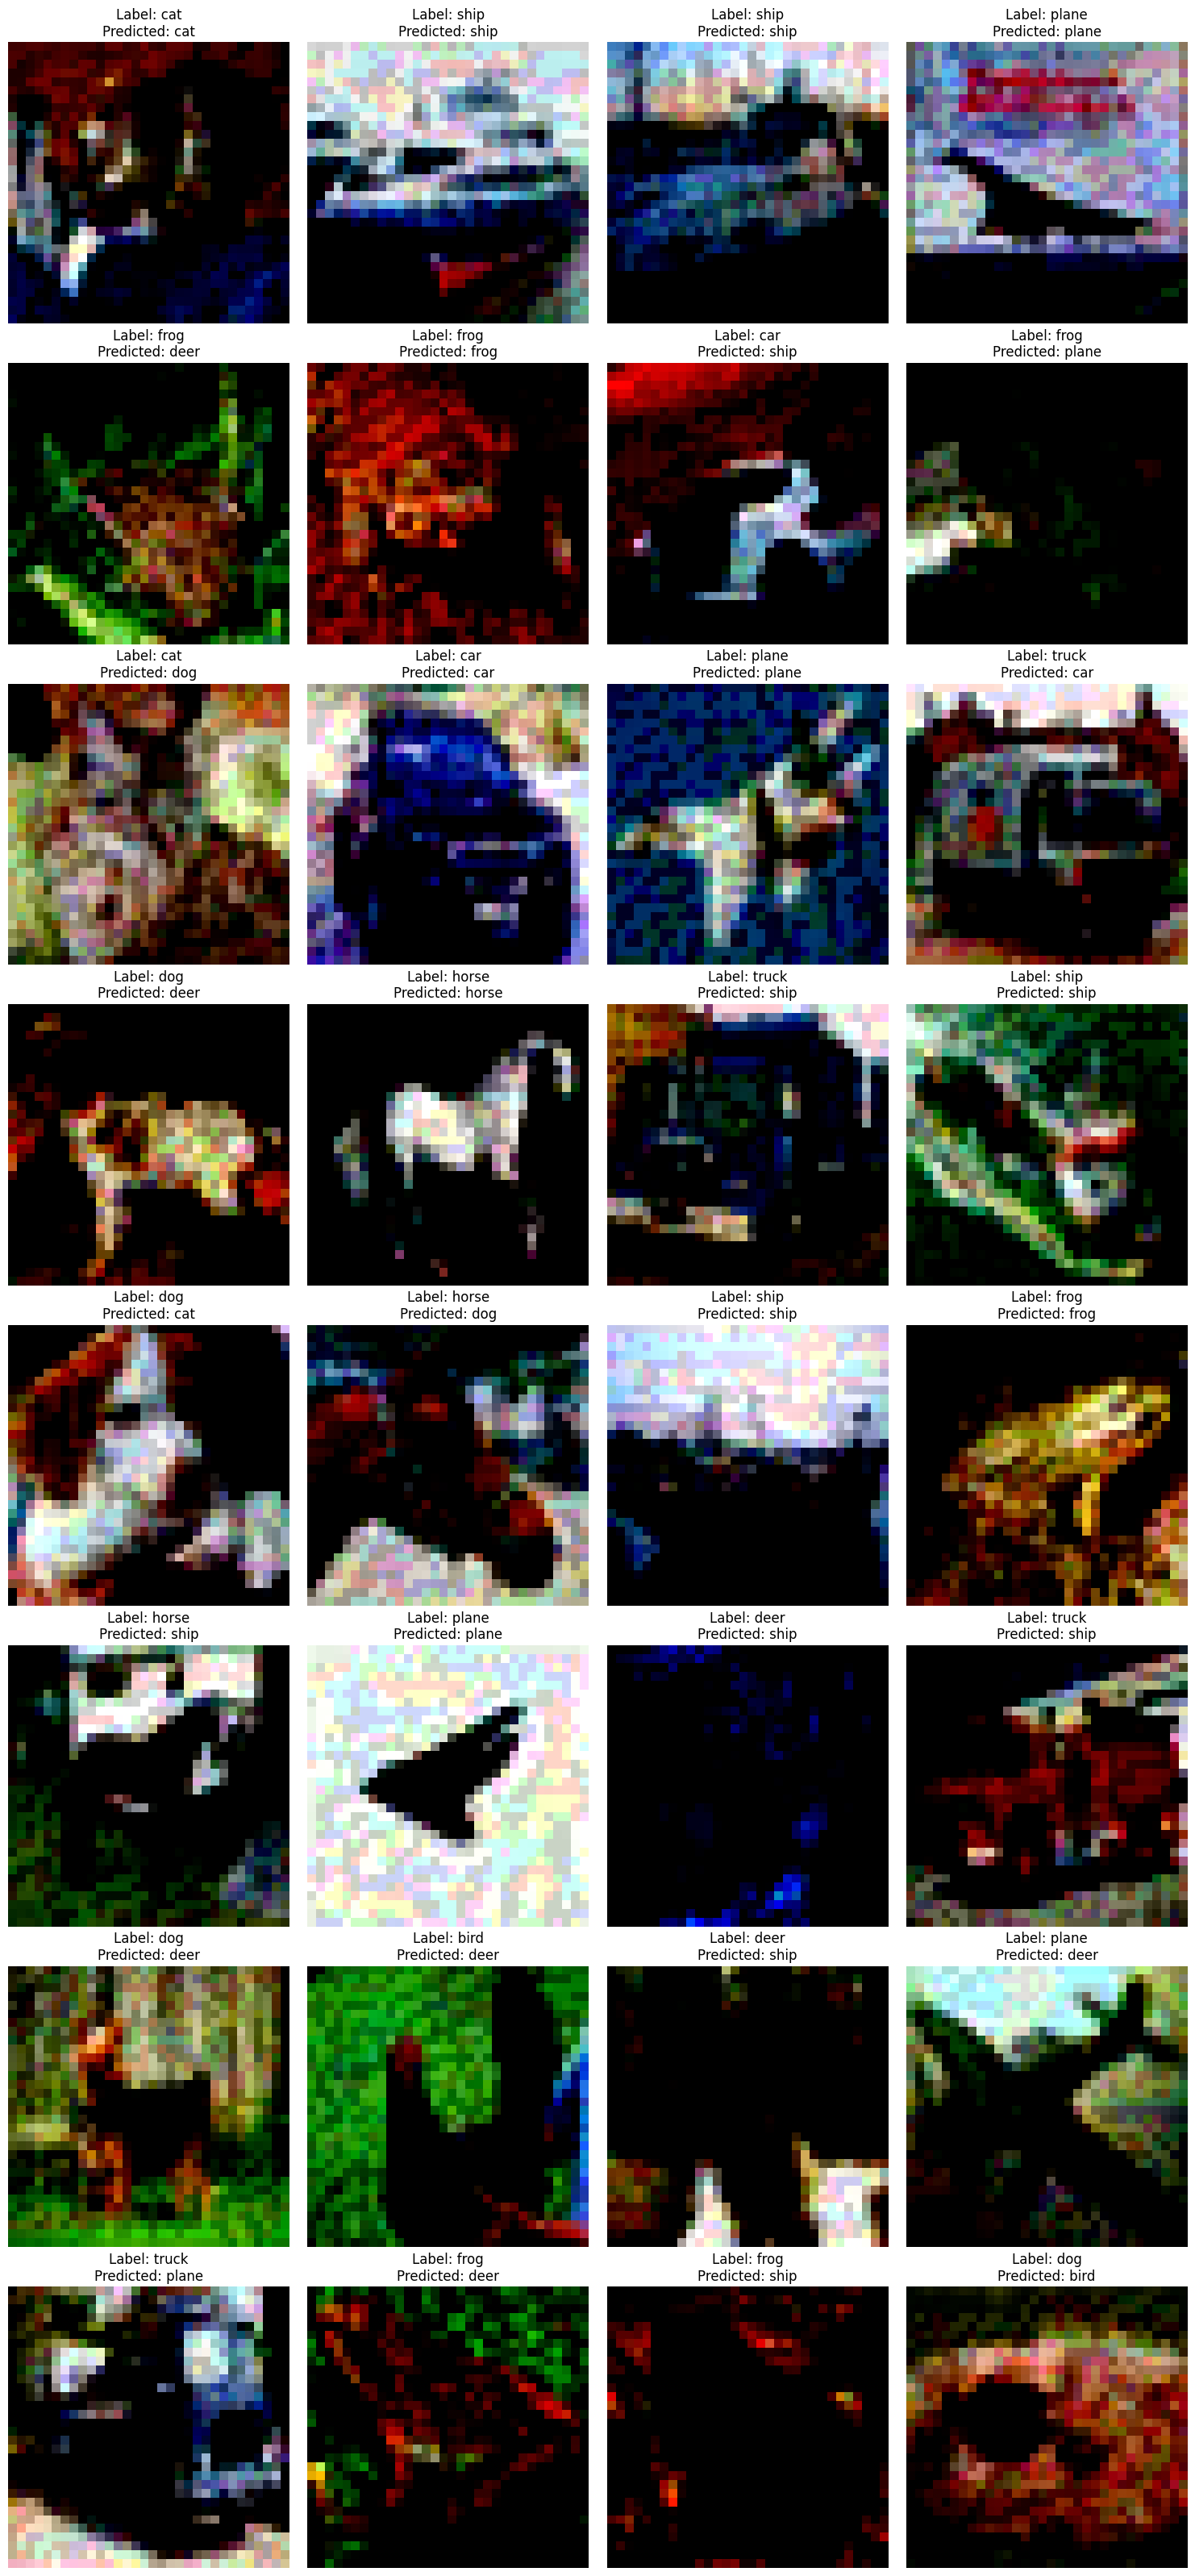

In [ ]:
print('After Perturbation with Standard Model')
display_grid(images_after_perturbation, titles_perturbed, num_images_per_row=4)

After Perturbation with Robust Model


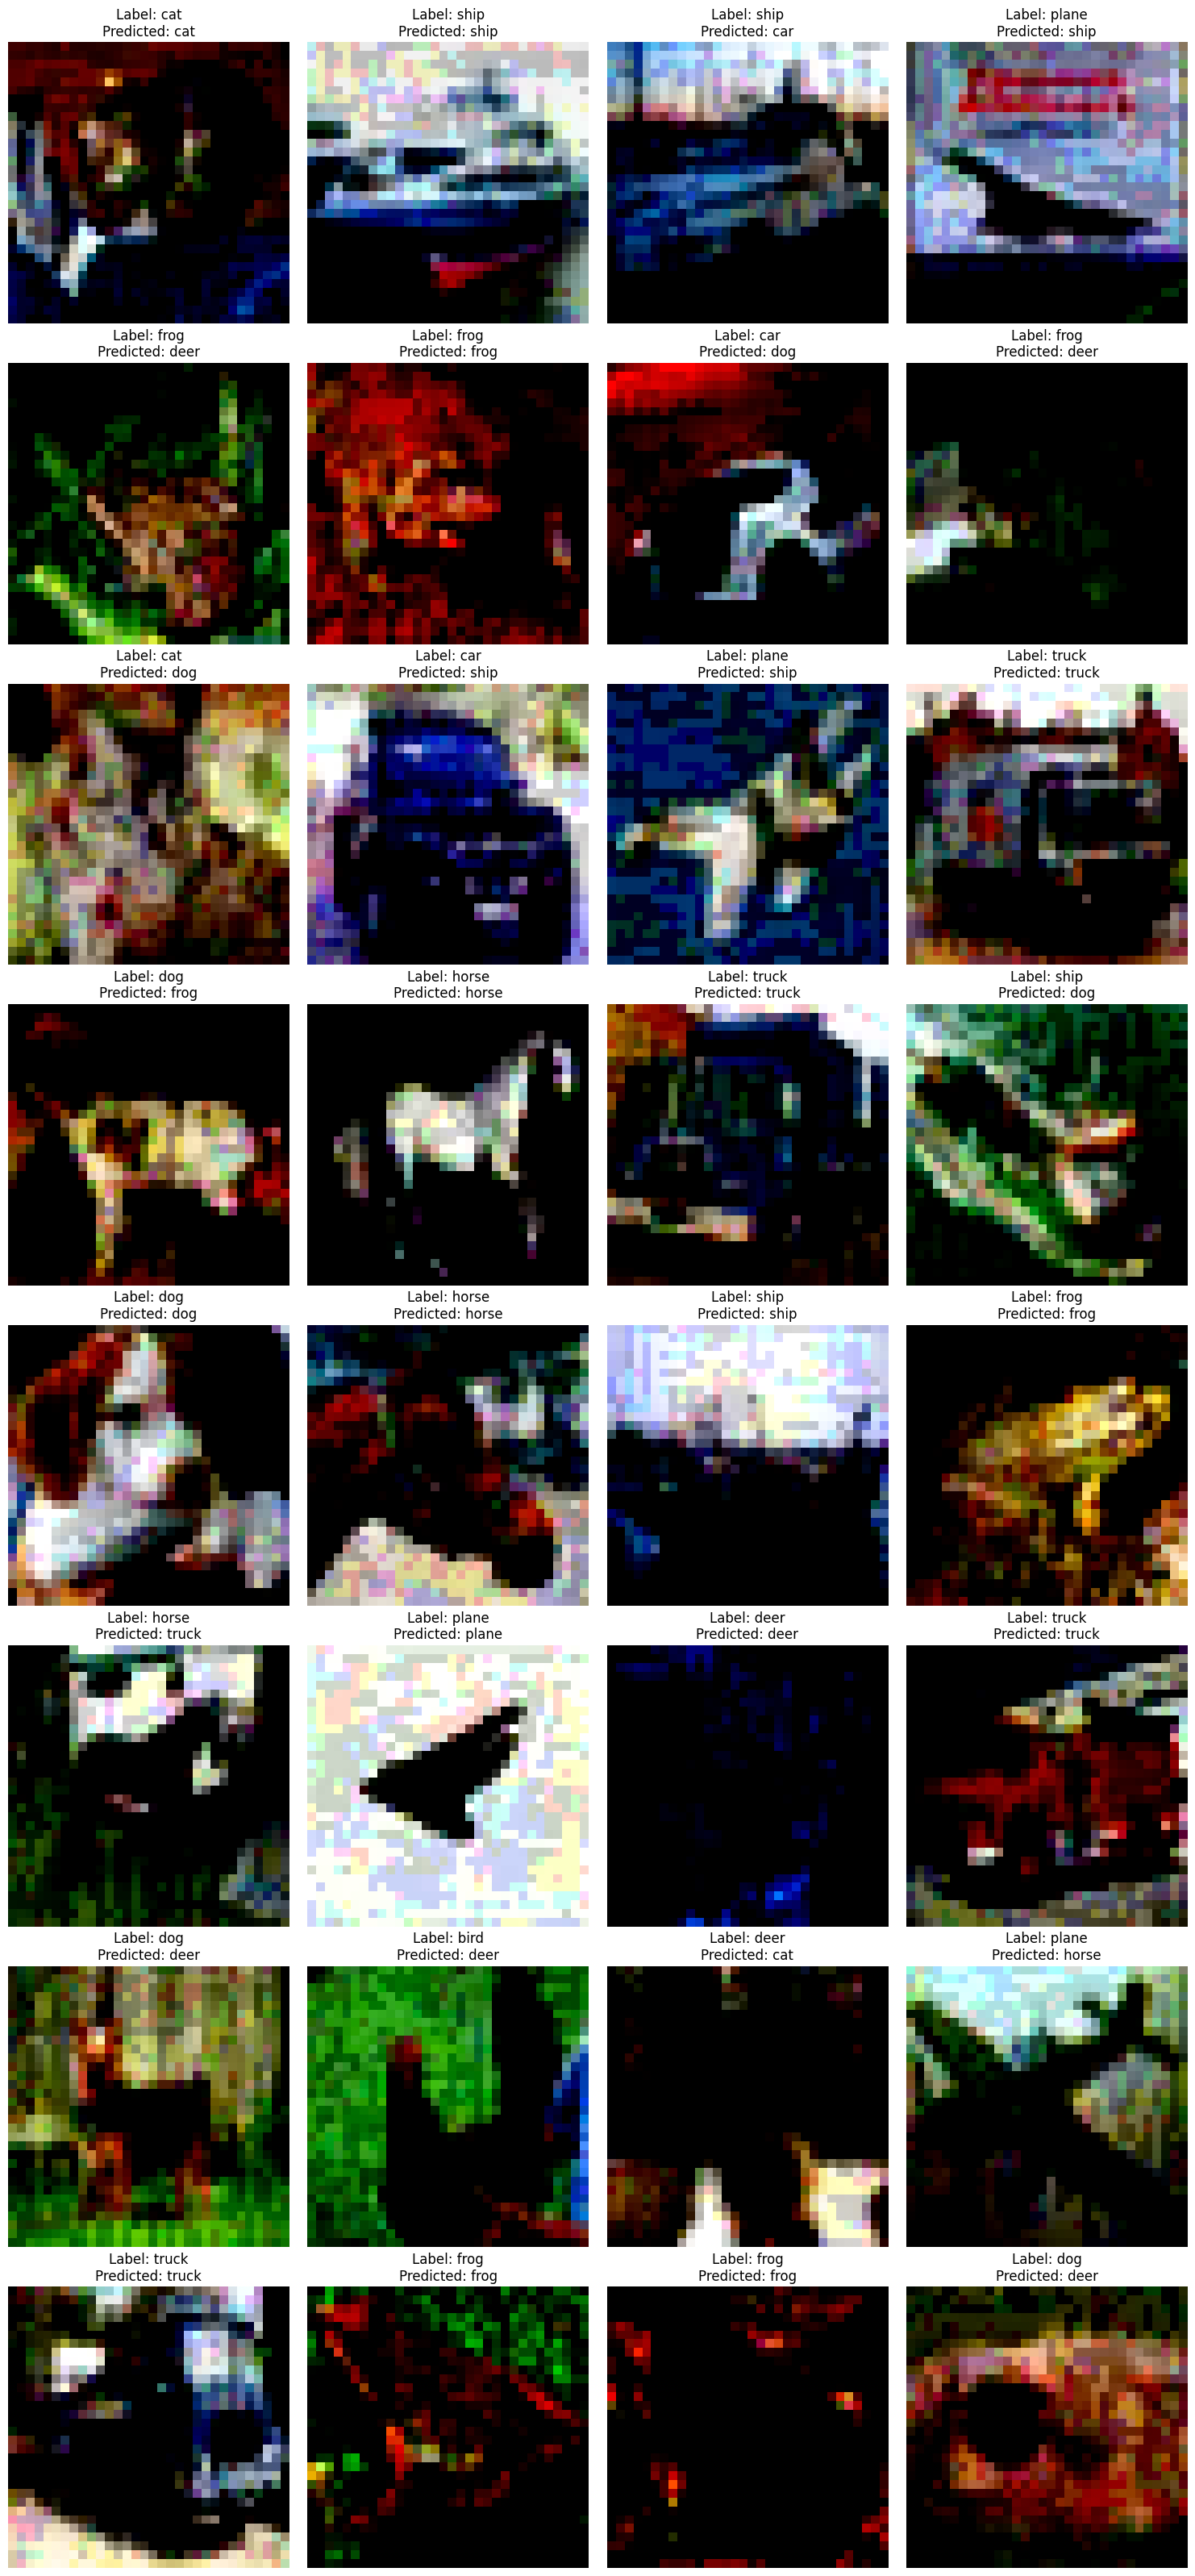

In [ ]:
print('After Perturbation with Robust Model')
display_grid(images_after_perturbation_robust, titles_perturbed_robust, num_images_per_row=4)